## Dependencies


In [63]:
import sys
import json
from pathlib import Path
from torchvision import datasets

## Utils


In [64]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

data_root = project_root / "data"
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook

setup_notebook()

Notebook setup completed. Project root added to sys.path: D:\Unlearning


In [65]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed

set_seed()

# Init model
from models.effnetb0 import init_model_effnetb0

# Create sisa structure
from methods.sisa.sisa_utils import create_sisa_structure

# Recreate sisa dataloaders from json file
from methods.sisa.sisa_utils import recreate_sisa_dataloaders

# SISA train & test loop
from methods.sisa.sisa_train_test import sisa_train, sisa_test, retrain_sisa_framework

# Aggregate SISA models, via weighted voting
from methods.sisa.sisa_utils import evaluate_aggregated_model, update_sisa_structure

Device used: cuda


## Parameters (arbitrary chosen)


In [66]:
BATCH_SIZE = 64

LEARNING_RATE = 0.001

EPOCHS = 3

SHARDS = 3

SLICES = 5

# stt.MULTI_GPU = True

# SISA structure


## Get data transform


In [67]:
*_, transform = init_model_effnetb0()
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Init model...
Done initializing model.
Model ID: 1670353738800, Optimizer ID: 1670353561024, Criterion ID: 1670353559200


## Load dataset


In [68]:
data_root = project_root / "data"

In [69]:
train_dataset = datasets.ImageFolder(root=data_root / "afhq/train", transform=transform)
test_dataset = datasets.ImageFolder(root=data_root / "afhq/val", transform=transform)

In [70]:
results_path = Path("D:/Unlearning/results/animal_faces/sisa")

## Create SISA structure


In [71]:
create_sisa_structure(train_dataset, shards=SHARDS, slices_per_shard=SLICES, results_path=results_path)

SISA structure saved to sisa_structure.json


In [72]:
sisa_structure_file = results_path / "sisa_structure.json"

## Prepare DataLoaders from json file


In [48]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=sisa_structure_file,
    batch_size=BATCH_SIZE,
    val_ratio=0.1,
)

In [49]:
len(dataloaders['shard_0']['slice_0']['train'])

14

# Train using SISA framework


## Models output path


In [51]:
save_models_metrics_dir = results_path / "sisa_models"

## Call train


In [ ]:
import time

start_time = time.perf_counter()

sisa_train(
    dataloaders=dataloaders,
    num_epochs=EPOCHS,
    save_models_metrics_dir=save_models_metrics_dir,
    init_model_func=init_model_effnetb0,
    learning_rate=LEARNING_RATE,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

## Call test


In [73]:
sisa_test(
    dataloaders=dataloaders,
    saved_models_metrics_dir=save_models_metrics_dir,
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True,
    results_path=results_path,
)

Init model...
Done initializing model.
Model ID: 1670024250896, Optimizer ID: 1670024256992, Criterion ID: 1670024265248
Loading and testing model: D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_0_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_0_final_model.pth: 100%|██████████| 24/24 [00:09<00:00,  2.57it/s]


Predictions and labels saved to D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 1670353433984, Optimizer ID: 1670353436624, Criterion ID: 1670353432688
Loading and testing model: D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_1_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_1_final_model.pth: 100%|██████████| 24/24 [00:09<00:00,  2.47it/s]


Predictions and labels saved to D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 1670354316608, Optimizer ID: 1670354316224, Criterion ID: 1670354316368
Loading and testing model: D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_2_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_2_final_model.pth: 100%|██████████| 24/24 [00:09<00:00,  2.46it/s]

Predictions and labels saved to D:\Unlearning\results\animal_faces\sisa\sisa_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to D:\Unlearning\results\animal_faces\sisa\sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)


In [74]:
with open(results_path / "sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9940
  Precision: 0.9940
  Recall: 0.9940
  F1 Score: 0.9940
Shard shard_1 Metrics:
  Accuracy: 0.9953
  Precision: 0.9954
  Recall: 0.9953
  F1 Score: 0.9953
Shard shard_2 Metrics:
  Accuracy: 0.9927
  Precision: 0.9927
  Recall: 0.9927
  F1 Score: 0.9927

Aggregated Model Metrics:
  Accuracy: 0.9967
  Precision: 0.9967
  Recall: 0.9967
  F1 Score: 0.9967


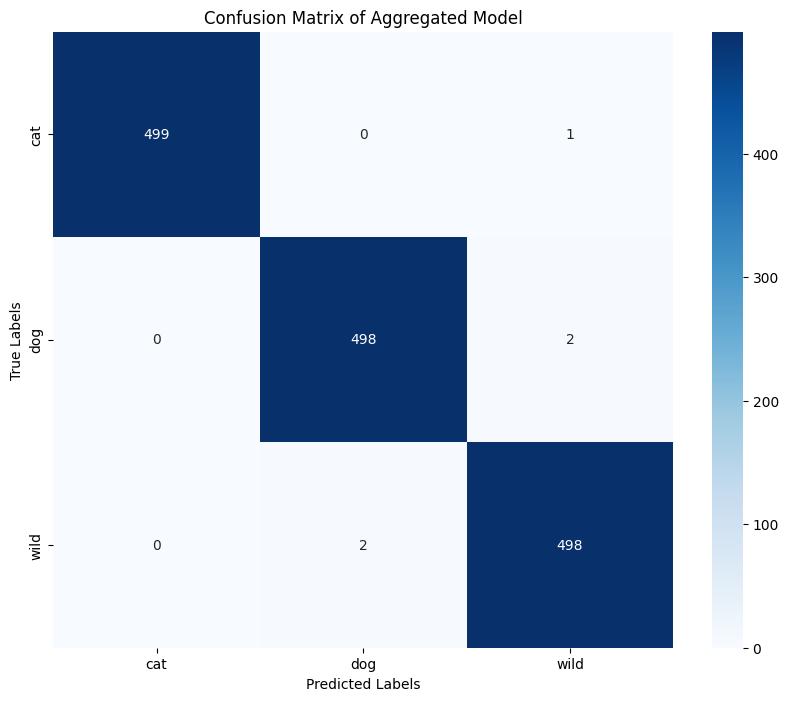

In [75]:
evaluate_aggregated_model(results, classes)

# SISA re-train


## Paths to data info


In [80]:
samples_to_delete = (
    project_root / "results/animal_faces/naive/afhq_samples_to_unlearn_30per.json"
)
sisa_structure = results_path / "sisa_structure.json"
updated_sisa_structure = results_path / "updated_sisa_strucute.json"
deleted_samples = results_path / "deleted_samples.json"

## Update sisa structure -> delete samples


In [77]:
affected_shards = update_sisa_structure(
    samples_to_delete, sisa_structure, updated_sisa_structure, deleted_samples
)

Retraining Plan:
  Shard: shard_0, Start from Slice: slice_0 onward
  Shard: shard_1, Start from Slice: slice_0 onward
  Shard: shard_2, Start from Slice: slice_0 onward


## Recreate DataLoaders from json file


In [81]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=updated_sisa_structure,
    batch_size=BATCH_SIZE,
    val_ratio=0.1,
)

In [82]:
len(dataloaders['shard_0']['slice_0']['train'])

10

## Models output path


In [59]:
save_path = results_path / "sisa_updated_models"

## Retrain the affected shards


In [ ]:
import time

start_time = time.perf_counter()

retrain_sisa_framework(
    dataloaders=dataloaders,
    affected_shards=affected_shards,
    num_epochs=EPOCHS,
    save_models_metrics_dir=save_path,
    init_model_func=init_model_effnetb0,
    learning_rate=LEARNING_RATE,
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

## Re-test new SISA models


In [83]:
sisa_test(
    dataloaders=dataloaders,
    saved_models_metrics_dir=save_path,
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True,
)

Init model...
Done initializing model.
Model ID: 1670353725008, Optimizer ID: 1670353717856, Criterion ID: 1670353720352
Loading and testing model: D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_0_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_0_final_model.pth: 100%|██████████| 24/24 [00:09<00:00,  2.59it/s]


Predictions and labels saved to D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 1670129939072, Optimizer ID: 1670129929856, Criterion ID: 1670129935472
Loading and testing model: D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_1_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_1_final_model.pth: 100%|██████████| 24/24 [00:09<00:00,  2.47it/s]


Predictions and labels saved to D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 1670353729280, Optimizer ID: 1670218605296, Criterion ID: 1670219448176
Loading and testing model: D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_2_EffNetB0_AFHQ


Evaluating model: D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_2_final_model.pth: 100%|██████████| 24/24 [00:09<00:00,  2.44it/s]

Predictions and labels saved to D:\Unlearning\results\animal_faces\sisa\sisa_updated_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)


In [84]:
with open(results_path / "sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9940
  Precision: 0.9940
  Recall: 0.9940
  F1 Score: 0.9940
Shard shard_1 Metrics:
  Accuracy: 0.9953
  Precision: 0.9954
  Recall: 0.9953
  F1 Score: 0.9953
Shard shard_2 Metrics:
  Accuracy: 0.9927
  Precision: 0.9927
  Recall: 0.9927
  F1 Score: 0.9927

Aggregated Model Metrics:
  Accuracy: 0.9967
  Precision: 0.9967
  Recall: 0.9967
  F1 Score: 0.9967


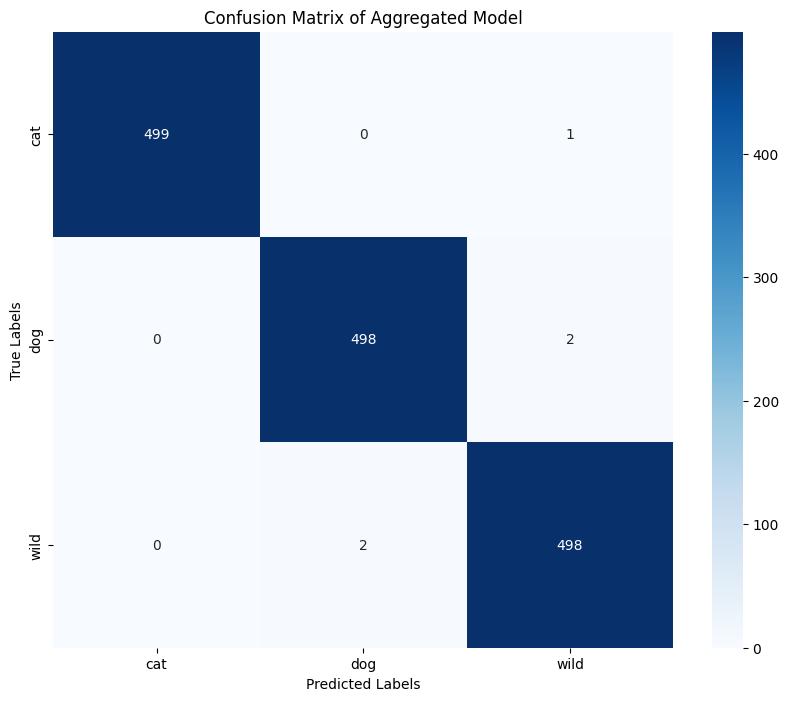

In [85]:
evaluate_aggregated_model(results, classes)